# Data Exploration and Cleaning

This notebook contains some exploration of the dataset and some cleaning for further analysis. The Readme file for the repository contains information on the data source. 

Because the CSV is compressed and present in the repository as a XZ file, and read directly compressed with Pandas.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

First, we load the data, and explore its structure

In [21]:
df = pd.read_csv("../data/bq-results-20240802-233415-1722641679845.csv.xz", 
                 compression='xz')
df.shape

(138864, 18)

In [22]:
df.head()

,scientific_name,contig_acc,biosample_acc,bioproject_acc,target_acc,element_symbol,protein_acc,type,class,subclass,taxgroup_name,strain,serovar,isolation_source,geo_loc_name,epi_type,host,collection_date
0,Salmonella enterica,AAFUZC010000051.1,SAMN03098832,NaN,PDT000041084.2,blaDHA,NaN,AMR,BETA-LACTAM,CEPHALOSPORIN,Salmonella enterica,AM49198,NaN,NaN,USA,clinical,NaN,NaN
1,Salmonella enterica,AAFUZC010000051.1,SAMN03098832,NaN,PDT000041084.2,ble,EBK1426116.1,AMR,BLEOMYCIN,BLEOMYCIN,Salmonella enterica,AM49198,NaN,NaN,USA,clinical,NaN,NaN
2,Salmonella enterica,AAFUZC010000051.1,SAMN03098832,NaN,PDT000041084.2,blaNDM-1,EBK1426117.1,AMR,BETA-LACTAM,CARBAPENEM,Salmonella enterica,AM49198,NaN,NaN,USA,clinical,NaN,NaN
3,Salmonella enterica,AAFUZC010000073.1,SAMN03098832,NaN,PDT000041084.2,blaNDM-1,EBK1426163.1,AMR,BETA-LACTAM,CARBAPENEM,Salmonella enterica,AM49198,NaN,NaN,USA,clinical,NaN,NaN
4,Salmonella enterica,AAFUZC010000073.1,SAMN03098832,NaN,PDT000041084.2,ble,EBK1426164.1,AMR,BLEOMYCIN,BLEOMYCIN,Salmonella enterica,AM49198,NaN,NaN,USA,clinical,NaN,NaN


In [23]:
df.columns

Index(['scientific_name', 'contig_acc', 'biosample_acc', 'bioproject_acc',
       'target_acc', 'element_symbol', 'protein_acc', 'type', 'class',
       'subclass', 'taxgroup_name', 'strain', 'serovar', 'isolation_source',
       'geo_loc_name', 'epi_type', 'host', 'collection_date'],
      dtype='object')

The dataset has 138,886 rows and 18 columns. The description of the columns is the following:

- scientific_name: the bacterial species name
- contig_acc: the contig accesion number from NCBI, where the gene is present
- biosample_acc: the biosample accession number
- bioproject_acc: the bioproject accession number
- target_acc: unsure, this seems to be an accession number for the genome assembly version
- element_symbol: the gene name (e.g. _blaNDM-1_)
- protein_acc: the protein accession number for the gene
- type: the type of mechanism (e.g. AMR, antimicrobial resistance)
- class: the functional class for the mechanism in this row
- subclass: the functional subclass for the mechanism in this row
- taxgroup_name: The taxonomic group. It may be similar to the scientific name, but unsure at the moment
- strain: the strain for this genome
- serovar: For some taxa, it could be a serovar classification.
- isolation_source: The biological source of the sample (it seems). For example, blood.
- geo_loc_name: the geographical origin of the isolate
- epi_type: needs some exploration, it seems to be the type of strain (clinical, maybe environmental?)
- host: The organism where this bacteria was isolated, for example _Homo sapiens_ (human)
- collection_date: The date where the isolate was collected.

Just from the first five rows, we can see that not all the columns are complete, and we need some additional filtering to have the data ready for analysis.

We can look in more detail the dataset, and use this information for further cleaning, including a description of the dataset, and looking at the NA values present in it

In [24]:
df.describe(include="all")

,scientific_name,contig_acc,biosample_acc,bioproject_acc,target_acc,element_symbol,protein_acc,type,class,subclass,taxgroup_name,strain,serovar,isolation_source,geo_loc_name,epi_type,host,collection_date
count,138864,138864,138864,26693,138864,138864,121804,138864,138007,138007,138864,98238,1983,104426,136244,124544,122637,132082
unique,96,41640,26809,692,26891,525,84585,3,37,64,32,18425,71,1268,907,2,107,3570
top,Escherichia coli,NZ_CP095443.1,SAMN27484493,PRJNA288601,PDT001315396.1,ble,WP_004201167.1,AMR,BETA-LACTAM,CARBAPENEM,E.coli and Shigella,308,not available,urine,USA,clinical,Homo sapiens,2023
freq,58548,109,129,5283,129,40865,7959,123952,46061,41690,58667,776,447,25639,40911,118880,116559,11480


In [25]:
df.isnull().sum()

scientific_name          0
contig_acc               0
biosample_acc            0
bioproject_acc      112171
target_acc               0
element_symbol           0
protein_acc          17060
type                     0
class                  857
subclass               857
taxgroup_name            0
strain               40626
serovar             136881
isolation_source     34438
geo_loc_name          2620
epi_type             14320
host                 16227
collection_date       6782
dtype: int64

One of the first questions is to find a unique identifier that can be used across the dataset. Each entry may have multiple rows associated, and variables such as `scientific_name` can be found multiple times. Looking at the description of the dataset some things that come up to attention:

- biosample_acc: This appears to be the best identifier. From NCBI, this refers is a unique identifier associated with the biological sample. There are no null values in this column.
- bioproject_acc: Not present in all of the rows. Not a good identifier.
- target_acc: according to the [NCBI documentation](https://www.ncbi.nlm.nih.gov/pathogens/pathogens_help/#isolates-browser-data-field-Isolate) it refers to the pathogen detection accession of the isolate. Probably could be used as an ID, but the number is higher compared to the biosample_acc. Maybe there is more than one genome assembly per biosample, this needs to be further explored.
- For further analysis and some of the questions, not all samples have isolation_source, geo_loc_name, host, and date, so we have to keep this in mind.

## Data Cleaning

First, we will subset the dataframe to only keep the columns that we will use for the analysis. In this case we will remove the columns: bioproject_acc, strain, and serovar

In [28]:
df.drop(columns=["bioproject_acc", "strain", "serovar"], inplace=True)
df.head()

,scientific_name,contig_acc,biosample_acc,target_acc,element_symbol,protein_acc,type,class,subclass,taxgroup_name,isolation_source,geo_loc_name,epi_type,host,collection_date
0,Salmonella enterica,AAFUZC010000051.1,SAMN03098832,PDT000041084.2,blaDHA,NaN,AMR,BETA-LACTAM,CEPHALOSPORIN,Salmonella enterica,NaN,USA,clinical,NaN,NaN
1,Salmonella enterica,AAFUZC010000051.1,SAMN03098832,PDT000041084.2,ble,EBK1426116.1,AMR,BLEOMYCIN,BLEOMYCIN,Salmonella enterica,NaN,USA,clinical,NaN,NaN
2,Salmonella enterica,AAFUZC010000051.1,SAMN03098832,PDT000041084.2,blaNDM-1,EBK1426117.1,AMR,BETA-LACTAM,CARBAPENEM,Salmonella enterica,NaN,USA,clinical,NaN,NaN
3,Salmonella enterica,AAFUZC010000073.1,SAMN03098832,PDT000041084.2,blaNDM-1,EBK1426163.1,AMR,BETA-LACTAM,CARBAPENEM,Salmonella enterica,NaN,USA,clinical,NaN,NaN
4,Salmonella enterica,AAFUZC010000073.1,SAMN03098832,PDT000041084.2,ble,EBK1426164.1,AMR,BLEOMYCIN,BLEOMYCIN,Salmonella enterica,NaN,USA,clinical,NaN,NaN


### Cleaning by columns

Looking at the `scientific_name` column, we can see that it includes a higher level of detail because it includes also serovar and/or subtype information, which is not needed here.

In [35]:
df.groupby("scientific_name").size()

scientific_name
Acinetobacter baumannii             6178
Acinetobacter baumannii ANC 4097       2
Acinetobacter baumannii P630           2
Acinetobacter baumannii ZW85-1         3
Acinetobacter lactucae                 5
                                    ... 
Vibrio alginolyticus                  60
Vibrio cholerae                      105
Vibrio fluvialis                      79
Vibrio parahaemolyticus               81
Vibrio vulnificus                     70
Length: 96, dtype: int64

In [36]:
df.groupby("taxgroup_name").size()

taxgroup_name
Acinetobacter baumannii          6459
Aeromonas hydrophila               63
Aeromonas veronii                  35
Citrobacter freundii             2458
E.coli and Shigella             58667
Enterobacter asburiae             204
Enterobacter bugandensis           12
Enterobacter chengduensis          24
Enterobacter chuandaensis           4
Enterobacter cloacae              406
Enterobacter hormaechei          6249
Enterobacter kobei                127
Enterobacter mori                  16
Enterobacter roggenkampii         261
Enterobacter sichuanensis          17
Enterococcus faecalis               2
Klebsiella oxytoca               1316
Klebsiella pneumoniae           53453
Kluyvera_intermedia                31
Morganella morganii               653
Pluralibacter gergoviae            71
Providencia alcalifaciens        3407
Pseudomonas aeruginosa           3439
Pseudomonas putida                 10
Salmonella enterica               639
Serratia marcescens               42

A quick look at the distribution of the scientific names shows that is dominated by the expected groups _E. coli / Shigella_ and _Klebsiella pneuomoniae_

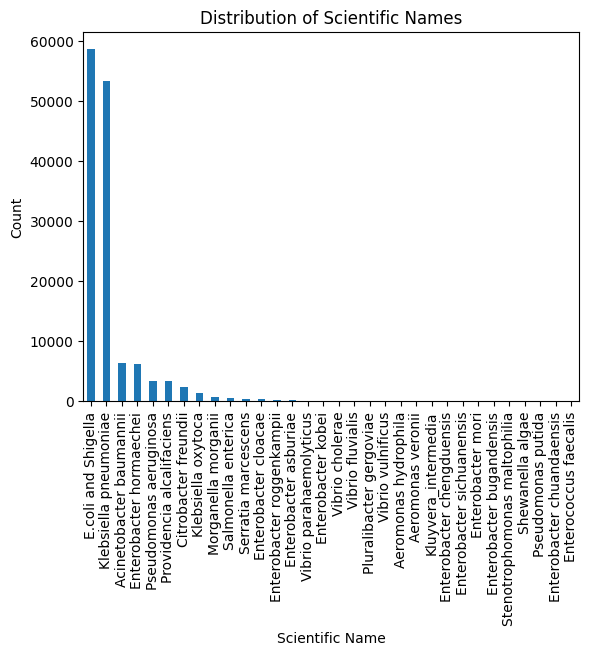

In [34]:
df['taxgroup_name'].value_counts().plot(kind='bar')
plt.title('Distribution of Scientific Names')
plt.xlabel('Scientific Name')
plt.ylabel('Count')
plt.show()


### Date cleaning

There is column with the date, that needs some cleaning, the information is mixed. A visual inspection of the data showed the following possiblities:

- No value
- Year only (e.g. 2018)
- Year and month (e.g. 2018-01)
- Full date (e.g. 2018-01-04)

For the purpose of this analysis, year only is ok, so we will modify the column to have the right format.


In [68]:
# Create functon to parse the date
def parse_date(date_str):
    """
    Parse a date string into a datetime object
    """
    if pd.isnull(date_str):
        return None
    try:
        if len(date_str) == 4:
            return datetime.strptime(date_str, '%Y').strftime('%Y')
        elif len(date_str) == 7:
            return datetime.strptime(date_str, '%Y-%m').strftime('%Y')
        elif len(date_str) == 10:
            return datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y')
    except ValueError:
        return None

# Apply the function to the collection_date column
df["year"] = df["collection_date"].apply(parse_date)

In [69]:
df["year"].head


<bound method NDFrame.head of 0         None
1         None
2         None
3         None
4         None
          ... 
138859    2015
138860    2015
138861    2016
138862    2016
138863    2016
Name: year, Length: 138864, dtype: object>

### Unknown values

The are several columns with unknown values. In most cases we can replace those with the string "Unknown", to reflect that properly on further analysis. 

In [70]:
df[["class", "subclass", "isolation_source", "geo_loc_name", "epi_type", "host"]].fillna("Unknown", inplace=True)

,class,subclass,isolation_source,geo_loc_name,epi_type,host
0,BETA-LACTAM,CEPHALOSPORIN,Unknown,USA,clinical,Unknown
1,BLEOMYCIN,BLEOMYCIN,Unknown,USA,clinical,Unknown
2,BETA-LACTAM,CARBAPENEM,Unknown,USA,clinical,Unknown
3,BETA-LACTAM,CARBAPENEM,Unknown,USA,clinical,Unknown
4,BLEOMYCIN,BLEOMYCIN,Unknown,USA,clinical,Unknown
...,...,...,...,...,...,...
138859,BLEOMYCIN,BLEOMYCIN,Unknown,Switzerland,clinical,Homo sapiens
138860,BETA-LACTAM,CARBAPENEM,Unknown,Switzerland,clinical,Homo sapiens
138861,BETA-LACTAM,CEPHALOSPORIN,Unknown,Switzerland,clinical,Homo sapiens
138862,BLEOMYCIN,BLEOMYCIN,Unknown,Switzerland,clinical,Homo sapiens


### Fix geographic location

Looking at the geographic location, some of the locations include more information than just the country. For this analysis I will only retain the country name


df['geo_loc_name'].value_counts().plot(kind='bar')
plt.title('Distribution of Scientific Names')
plt.xlabel('Scientific Name')
plt.ylabel('Count')
plt.show()

In [72]:
# Quic overview
df['geo_loc_name'].value_counts()

geo_loc_name
USA                     40911
China                    5492
France                   5087
United Kingdom           5057
Singapore                4892
                        ...  
South Africa: Benoni        1
India:Tamilnadu             1
Myanmar: Yangon             1
Chile:Temuco                1
Bulgaria:Burgas             1
Name: count, Length: 907, dtype: int64

In [73]:
# Create a new conuntry variable
df["country"] = df["geo_loc_name"].str.split(":").str[0]
df['country'].value_counts()

country
USA               44865
China             21600
United Kingdom     5754
France             5590
Thailand           5525
                  ...  
Burkina Faso          4
Puerto Rico           4
Afghanistan           4
Jamaica               4
Sri Lanka             2
Name: count, Length: 115, dtype: int64

### Save dataset

With the clean and processed dataset, I will save this to a new table, also compressed with XZ for portability

In [74]:
df.to_csv("../data/20240804_clean_data.csv.xz", index=False, compression='xz')